# reg_part_B_NN

# Data import libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch

In [5]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [6]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Artificial Neural Network for Regression

In [39]:
X = data.drop(columns=['time']).values
y = data['time'].values.reshape(-1, 1)

N, M = X.shape

input_dim  = M # M number of features
output_dim = 1 # regression problem

# X.shape, y.shape print shapes of X and y to undestand their dimensions


In [40]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X.shape, y.shape, X_test.shape, y_test.shape, print shapes of X, y, X_test and y_test to understand their dimensions after the split

In [41]:
def get_model(input_dim, hidden_dim, output_dim):
    ### BEGIN SOLUTION
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.Tanh(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
    )
    ### END SOLUTION

In [43]:
# Normalize data based on training set

def get_fold_data(X, y, train_idx, val_idx):
   
    X_train = X[train_idx]
    X_val   = X[val_idx]
    y_train = y[train_idx]
    y_val   = y[val_idx]

    mean = X_train.mean(axis=0)
    std  = X_train.std(axis=0)

    X_train_norm = (X_train - mean) / std
    X_val_norm   = (X_val   - mean) / std

    return X_train_norm, X_val_norm, y_train, y_val

# Tensor conversion

def torch_tensor_conversion(X_train, y_train, X_val, y_val):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

Fold 1/10
  Hidden units: 1, Validation set MSE: 6967.0376
  Hidden units: 2, Validation set MSE: 6494.8188
  Hidden units: 3, Validation set MSE: 5212.7104
  Hidden units: 4, Validation set MSE: 4093.7415
  Hidden units: 5, Validation set MSE: 9030.2246
  Hidden units: 6, Validation set MSE: 4663.7427
  Hidden units: 7, Validation set MSE: 7297.7988
  Hidden units: 8, Validation set MSE: 6069.7007
  Hidden units: 9, Validation set MSE: 5852.1582
  Hidden units: 10, Validation set MSE: 6659.2993
Fold 2/10
  Hidden units: 1, Validation set MSE: 6888.5977
  Hidden units: 2, Validation set MSE: 8210.1543
  Hidden units: 3, Validation set MSE: 8165.4766
  Hidden units: 4, Validation set MSE: 6560.4429
  Hidden units: 5, Validation set MSE: 8892.8994
  Hidden units: 6, Validation set MSE: 10711.5576
  Hidden units: 7, Validation set MSE: 7603.1890
  Hidden units: 8, Validation set MSE: 8942.1221
  Hidden units: 9, Validation set MSE: 9424.0459
  Hidden units: 10, Validation set MSE: 8672.96

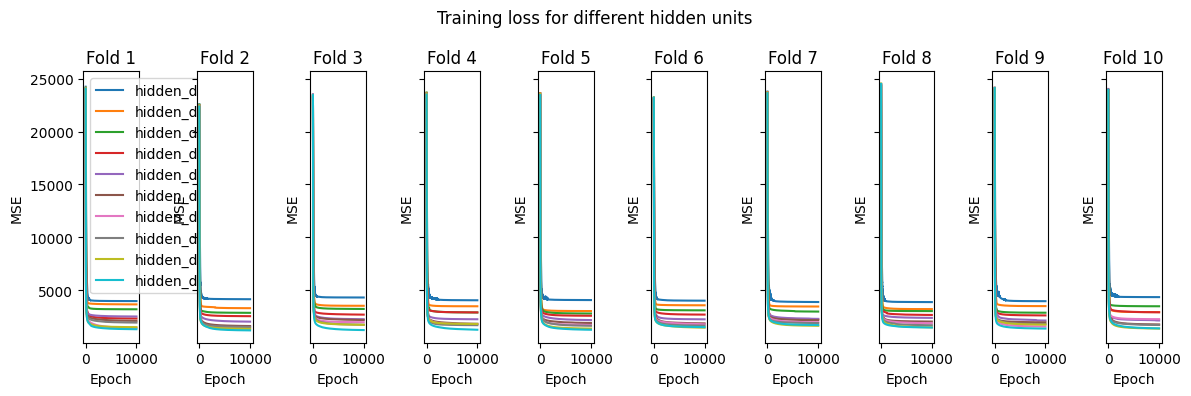

In [76]:
K = 10
CV = KFold(K, shuffle=True, random_state=0)
# initilize lists to store results

# Define hyperparameters
lr = 1e-3 # lr = learning rate: step size used by the optimizer when updating weights.
n_epochs = 10000 # n_epochs = number of times the entire training dataset is passed through the model during training.

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results = {}

for k, (train_index, val_index) in enumerate(CV.split(X, y)):
    print(f'Fold {k+1}/{K}')

    # Get fold data using the helper function defined above get_fold_data
    X_train, X_val, y_train, y_val = get_fold_data(X, y, train_index, val_index)

    # Convert to torch tensors
    X_train, y_train, X_val, y_val = torch_tensor_conversion(X_train, y_train, X_val, y_val)

    #Set up a dictionary to store the results for each hyperparameter setting
    results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

    # Loop over the hyperparameter settings        
    for hidden_dim in hyperparameters_to_tune:
         # Define a model instance with a specific number of hidden units
         model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

         # Define loss criterion
         criterion = torch.nn.MSELoss()

         # Define the optimizer as the Adam optimizer (not needed to know the details)
         # We need to decide if we want to use gradient descent or stochastic gradient descent with batches
         # Stochastic Gradient Descent is faster for larger datasets
         # The data that we are working with is small so we can use gradient descent
         optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.4) 

         for epoch in range(n_epochs):
            # Set the model to training mode
            model.train()

            # Make a forward pass through the model to compute the outputs
            outputs = model(X_train)
            # Compute the loss
            loss = criterion(outputs, y_train)

            # Make sure that the gradients are zero before you use backpropagation
            optimizer.zero_grad()
            # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
            loss.backward()
            # Update the model parameters by making the optimizer take a gradient descent step
            optimizer.step()

            # Store the training loss for this epoch in the dictionary
            results_inner[hidden_dim]['train'].append(loss.item())

            # Compute the final test loss on the test set
         with torch.no_grad(): # No need to compute gradients for the validation set
            model.eval()
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            results_inner[hidden_dim]['val'].append(val_loss.item())
            print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

    # Store the results for this fold
    results[k] = results_inner


# Plot the loss curves for each fold and hyperparameter setting
fig, axs = plt.subplots(1, K, figsize=(12, 4), sharey=True, sharex=True)
# Plot the training loss for each fold and hyperparameter setting
for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        # Plot the training loss for this hyperparameter setting
        axs[fold].plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')

    # Set the title and labels for each subplot
    axs[fold].set_title('Fold {}'.format(fold+1))
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('MSE')

# Set the overall title and show the legend
plt.suptitle('Training loss for different hidden units')
plt.tight_layout()
axs[0].legend()
plt.show()

In [73]:
results_dict = {}

for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        results_dict.setdefault(fold, {}).setdefault(hidden_dim, {})
        results_dict[fold][hidden_dim]['val'] = results[fold][hidden_dim]['val']

means = {}
for hp in hyperparameters_to_tune:
    vals = []
    for fold in results.values():
        if hp in fold:
            vals.extend(fold[hp]['val'])
    if vals:
        means[hp] = sum(vals) / len(vals)
    else:
        means[hp] = None  # or np.nan if using numpy

for k, v in means.items():
    print(f"{k}: {v}")

1: 5841.377685546875
2: 6075.6866455078125
3: 5919.47861328125
4: 6353.69658203125
5: 6391.559252929687
10: 6529.178173828125
20: 7179.81484375
35: 6672.525341796875
50: 6839.419897460937
100: 6710.800830078125
300: 6422.514477539063
600: 6787.057788085937


For one simulation with K=10 we got this mean eror in validation set

1: 5841.377685546875

2: 6075.6866455078125

3: 5919.47861328125

4: 6353.69658203125

5: 6391.559252929687

10: 6529.178173828125

20: 7179.81484375

35: 6672.525341796875

50: 6839.419897460937

100: 6710.800830078125

300: 6422.514477539063

600: 6787.057788085937

In [77]:
results_dict = {}

for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        results_dict.setdefault(fold, {}).setdefault(hidden_dim, {})
        results_dict[fold][hidden_dim]['val'] = results[fold][hidden_dim]['val']

means = {}
for hp in hyperparameters_to_tune:
    vals = []
    for fold in results.values():
        if hp in fold:
            vals.extend(fold[hp]['val'])
    if vals:
        means[hp] = sum(vals) / len(vals)
    else:
        means[hp] = None  # or np.nan if using numpy

for k, v in means.items():
    print(f"{k}: {v}")

1: 6021.08212890625
2: 6340.252685546875
3: 5609.96689453125
4: 5697.902758789062
5: 7280.750927734375
6: 6347.315185546875
7: 6565.63740234375
8: 6694.7796630859375
9: 6368.17783203125
10: 5670.708642578125
